## Capstone Project Priscilla (0206021810012)
### Medical Cost, Regression
source: https://www.kaggle.com/mirichoi0218/insurance

**import semua yang diperlukan**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.eval_measures import rmse
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import Axes3D

# Preprocessing

**masukkan csv ke dalam dataframe, lalu cetak info mengenai dataframe**

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/pvannyamelia/dsc_kuliah/main/data_science/assets_dsc/insurance.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


*tidak ada missing values pada semua kolom, DataFrame berukuran 1338 rows dengan 6 kolom fitur dan 1 kolom target*

**cetak 10 data pertama untuk melihat gambaran data**

In [3]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


Berdasarkan jenis data:
* nominal: gender, smoker, region
* ordinal: -
* interval: bmi
* ratio: children, age, charges

**karena ada data yang berupa string, gunakan LabelEncoder untuk mengubah data string menjadi data numeric**

In [4]:
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex']) #female = 0
df['smoker'] = le.fit_transform(df['smoker']) #yes = 1
df['region'] = le.fit_transform(df['region']) #southwest = 3, southeast = 2, northwest = 1, northeast = 0

In [5]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
5,31,0,25.740,0,0,2,3756.62160
6,46,0,33.440,1,0,2,8240.58960
7,37,0,27.740,3,0,1,7281.50560
8,37,1,29.830,2,0,0,6406.41070
9,60,0,25.840,0,0,1,28923.13692


**Hapus yang duplicate**

In [6]:
dupl = list(df[df.duplicated()==True].index)
print(dupl)
print("Shape Before: ", df.shape)
df.drop(df.index[dupl], inplace=True)
print("Shape After: ", df.shape)

[581]
Shape Before:  (1338, 7)
Shape After:  (1337, 7)


**Gunakan .describe() untuk melihat statistik deskriptif tiap kolom**

In [7]:
df.describe()

,age,sex,bmi,children,smoker,region,charges
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,0.504862,30.663452,1.095737,0.204936,1.516081,13279.121487
std,14.044333,0.500163,6.100468,1.205571,0.403806,1.105208,12110.359656
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.290000,0.000000,0.000000,1.000000,4746.344000
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9386.161300
75%,51.000000,1.000000,34.700000,2.000000,0.000000,2.000000,16657.717450
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


*dari statistik deskriptif tiap kolom, dapat diamati bahwa mean dan median kolom age, bmi, children tidak terlalu jauh berbeda*


*namun, mean dan median kolom charges terlampau jauh berbeda --> kemungkinan ada outlier*


*meskipun mean dan median bmi tidak jauh berbeda, namun Q3 kolom bmi jika dibandingkan dengan max, jaraknya cukup jauh*


*meskipun mean dan median age tidak jauh berbeda, namun jarak antara median & mean age dengan max, jaraknya cukup jauh*

**berdasarkan analisa tabel statistik deskriptif, periksa apakah ada outlier, menggunakan visualisasi data boxplot pada kolom-kolom yang dicurigai**

<AxesSubplot:>

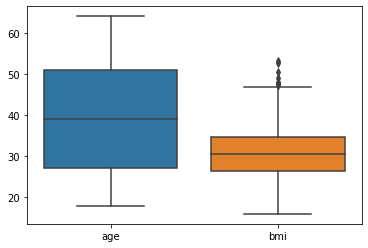

In [8]:
sns.boxplot(data=df[['age', 'bmi']])

Text(0.5, 0, 'charges')

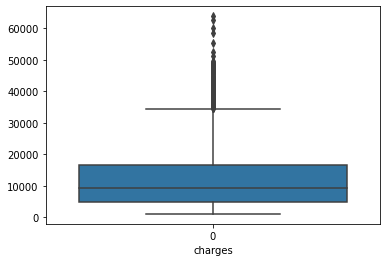

In [9]:
sns.boxplot(data=df['charges'])
plt.xlabel('charges')

*Berdasarkan visualisasi, terdapat outlier pada kolom bmi dan charges*

**Cari outlier dengan z-score**

*baris dengan nilai mutlak z > 3 adalah outlier*

In [10]:
df['z_bmi'] = np.abs(stats.zscore(df['bmi']))
outlBmi = list(np.where(np.abs(df['z_bmi']) > 3)[0])
print("BMI Outliers: ", outlBmi)
print("Total outlier BMI: ", len(outlBmi), "\n")

df['z_charges'] = np.abs(stats.zscore(df['charges']))
outlCharges = list(np.where(np.abs(df['z_charges']) > 3)[0])
print("Charges Outliers: ", outlCharges)
print("Total outlier Charges: ", len(outlCharges))

outl = list(set(outlBmi + outlCharges))

BMI Outliers:  [116, 846, 1046, 1316]
Total outlier BMI:  4 

Charges Outliers:  [34, 543, 577, 818, 1145, 1229, 1299]
Total outlier Charges:  7


In [11]:
df.iloc[outl, :]

,age,sex,bmi,children,smoker,region,charges,z_bmi,z_charges
577,31,0,38.095,1,1,0,58571.07448,1.218649,3.741334
34,28,1,36.400,1,1,3,51194.55914,0.940697,3.131998
1317,18,1,53.130,0,0,2,1163.46270,3.684136,1.000812
1230,52,1,34.485,3,1,1,60021.39897,0.626670,3.861138
847,23,1,50.380,1,0,2,2438.05520,3.233182,0.895524
819,33,0,35.530,0,1,1,55135.40209,0.798032,3.457531
1300,45,1,30.360,0,1,2,62592.87309,0.049761,4.073554
116,58,1,49.060,0,0,2,11381.32540,3.016724,0.156767
1047,22,1,52.580,1,1,2,44501.39820,3.593945,2.579111
1146,60,1,32.800,0,1,3,52590.82939,0.350358,3.247337


**Drop rows dengan index outlier**

In [12]:
print(df.shape)
df.drop(df.index[list(outl)], inplace=True)
print(df.shape)

(1337, 9)
(1326, 9)


In [13]:
df.describe()

,age,sex,bmi,children,smoker,region,charges,z_bmi,z_charges
count,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000
mean,39.227753,0.503017,30.570743,1.099548,0.200603,1.513575,13039.837572,0.795150,0.734449
std,14.037019,0.500180,5.992764,1.207167,0.400603,1.106842,11677.031551,0.577247,0.625285
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900,0.003534,0.004153
25%,27.000000,0.000000,26.220000,0.000000,0.000000,1.000000,4740.287150,0.333960,0.314147
50%,39.000000,1.000000,30.300000,1.000000,0.000000,2.000000,9303.297725,0.689393,0.620531
75%,51.000000,1.000000,34.560000,2.000000,0.000000,2.000000,16389.832412,1.149268,0.910357
max,64.000000,1.000000,48.070000,5.000000,1.000000,3.000000,49577.662400,2.854381,2.998435


<AxesSubplot:>

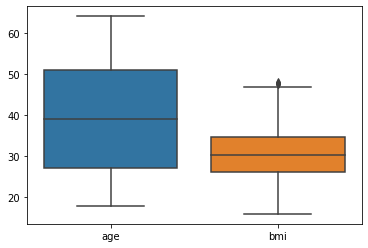

In [14]:
sns.boxplot(data=df[['age', 'bmi']])

Text(0.5, 0, 'charges')

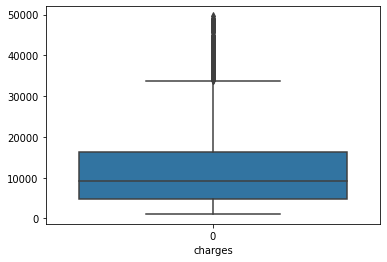

In [15]:
sns.boxplot(data=df['charges'])
plt.xlabel('charges')

**Cari korelasi antar variabel pada tabel**

Text(0.5, 1.0, 'Korelasi Antar Variabel')

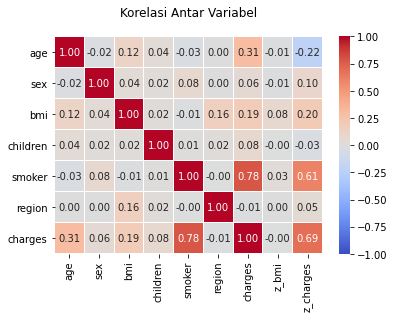

In [16]:
corr = df.corr()
sns.heatmap(corr[:-2], vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Korelasi Antar Variabel", pad=20)

*Dari heatmap dapat dilihat bahwa:*

*1. dataset yang digunakan sudah cukup bagus (tidak ada keterkaitan yang signifikan antar variabel independen)*

*2. jenis kelamin, jumlah anak, dan tempat tinggal tidak signifikan berpengaruh terhadap charges*

**Skewness: pastikan distribusi data seimbang agar tidak menimbulkan bias**

**split dataset**

In [17]:
df1 = df[['age', 'bmi', 'smoker', 'charges']]
df2 = df[['sex', 'children', 'region', 'charges']]

**Cek distribusi data**

In [18]:
df1.skew()

age        0.054134
bmi        0.203657
smoker     1.496989
charges    1.452917
dtype: float64

Source: https://towardsdatascience.com/skewness-kurtosis-simplified-1338e094fc85

* low skewness: [-0.5, 0.5]

* moderate skewness: [-1, -0.5) U (0.5, 1]

* high skewness: <-1, >1

berdasarkan keterangan di atas, dapat disimpulkan bahwa kolom 'charges' memiliki nilai skewness yang tinggi. oleh karena itu kita 

**Handle Skewness using Log Transformation**

In [19]:
dfUsed = np.log10(df1[['age', 'charges']])
dfUsed = dfUsed.join(df1[['smoker', 'bmi']])
dfUsed = dfUsed[['age', 'bmi', 'smoker', 'charges']]

# Building the model

reference: https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833

In [20]:
dfUsed.head()

,age,bmi,smoker,charges
0,1.278754,27.900,1,4.227499
1,1.255273,33.770,0,3.236928
2,1.447158,33.000,0,3.648308
3,1.518514,22.705,0,4.342116
4,1.505150,28.880,0,3.587358


**pisahkan dataset menjadi variabel dependen (y) dan variabel independen (X)**

In [21]:
X = dfUsed.iloc[:, :-1].values
y = dfUsed.iloc[:, -1].values

**Bangun model linear regression**

In [22]:
scores=[] #to store r squared
rmse_list=[] #to store RMSE
lrmodel = LinearRegression()
cv = KFold(n_splits=10, random_state=42, shuffle=True)
for train_index, test_index in cv.split(X):
#     print("Train index: ", train_index, "\n")
#     print("Test index: ", test_index)
    
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    lrmodel.fit(X_train, y_train)
    y_predict = lrmodel.predict(X_test)
    scores.append(lrmodel.score(X_test, y_test))
    rmse_fold = rmse(y_test, y_predict)
#     print(rmse_fold)
    rmse_list.append(rmse_fold)

lm = smf.ols(formula='charges ~ age + bmi + smoker', data = dfUsed).fit()
comparison = pd.DataFrame({"y_test": y_test, "y_predict": y_predict})
print("Summary: ", lm.summary())
print("R Squared Mean: ", np.mean(scores))
print("RMSE mean: ", np.mean(rmse_list))

Summary:                              OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     1302.
Date:                Fri, 15 Jan 2021   Prob (F-statistic):               0.00
Time:                        10:43:38   Log-Likelihood:                 263.10
No. Observations:                1326   AIC:                            -518.2
Df Residuals:                    1322   BIC:                            -497.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6725      0.056     30.13

In [23]:
comparison.sample(10)

,y_test,y_predict
92,4.101905,4.110685
27,4.111558,4.083697
11,4.597218,4.592449
53,3.328060,3.457736
96,3.876104,3.888881
8,4.479790,4.744523
85,3.737037,3.749616
5,3.694584,3.758173
32,3.915539,3.925834
51,3.971337,3.953690


**Visualisasi korelasi antar variabel**

<AxesSubplot:>

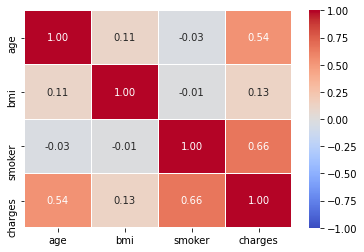

In [24]:
corr = dfUsed.corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)

**Visualisasi model dalam 3D**

In [25]:
X1 = dfUsed.iloc[:, :-2].values
y1 = dfUsed.iloc[:, -1].values
lrmodel1 = LinearRegression()

for train_index, test_index in cv.split(X1):
    X_train1, X_test1, y_train1, y_test1 = X1[train_index], X1[test_index], y1[train_index], y1[test_index]
    fit = lrmodel1.fit(X_train1, y_train1)

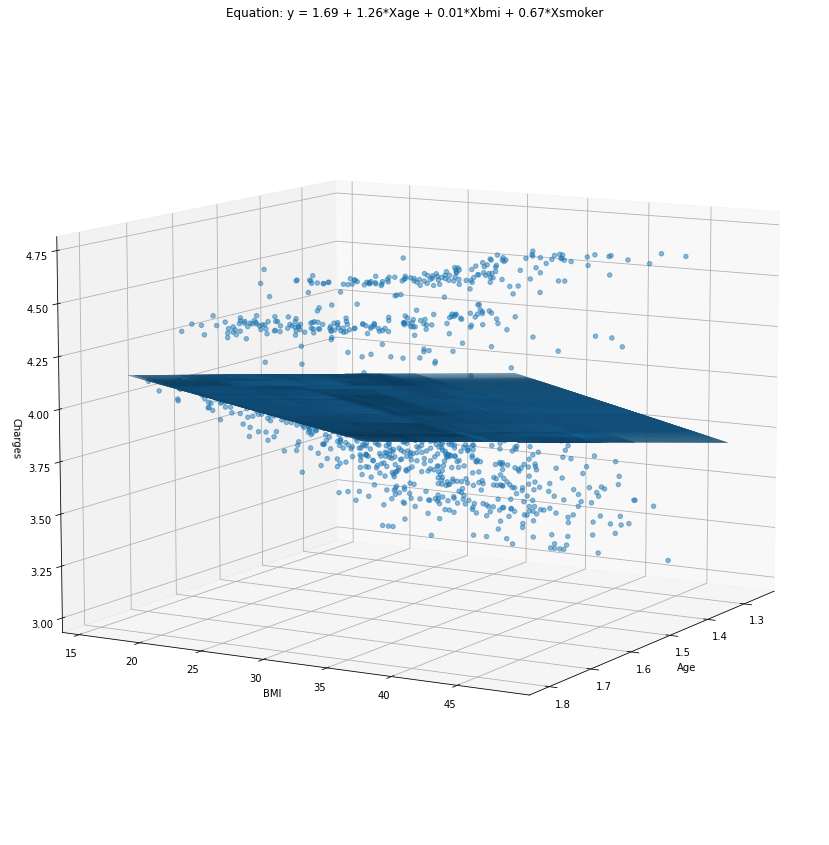

In [30]:
coefs = lrmodel.coef_
intercept = lrmodel.intercept_
x = X[:, 0] #age
y = X[:, 1] #bmi
z = y

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, marker='o', alpha=0.5)
ax.set_xlabel("Age")
ax.set_ylabel("BMI")
ax.set_zlabel("Charges")
ax.set_title("Equation: y = {:.2f} + {:.2f}*Xage + {:.2f}*Xbmi + {:.2f}*Xsmoker".format(intercept, coefs[0], coefs[1], coefs[2]))
xx, yy = np.meshgrid(x, y)
exog1 = pd.DataFrame({'age':xx.ravel(), 'bmi':yy.ravel()})
out=fit.predict(exog1)

ax.plot_surface(xx, yy, out.reshape(xx.shape), alpha=0.1)
ax.view_init(10, 30)
plt.show()

**coba prediksi dengan data baru**

In [29]:
# age, bmi, smoker
def prediksi(age, bmi, perokok):
#     whatif = np.log10(np.array([[age, bmi]]))
    whatif = np.log10(np.array([[age]]))
    whatif = np.append(whatif, [bmi, perokok]) #status perokok, 0: non perokok, 1: perokok
    status = "perokok" if perokok==1 else "bukan perokok"
    print("Prediksi healtcare cost untuk usia", age, "tahun, bmi:", bmi," dan", status, np.power(10, lrmodel.predict([whatif])))
    
prediksi(age=19, bmi=27.9, perokok=1)

Prediksi healtcare cost untuk usia 19 tahun, bmi: 27.9  dan perokok [13036.03411795]
